# Deep Q-Network (DQN)

The main difference with NFQ are the use of an exponentially decaying epsilon-greedy strategy, the use of a replay buffer and the use of a target network ib order to simulate a IID problem and a more stable target.

In [22]:
import gym
env = gym.make('CartPole-v1')

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        
        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        # creating the hidden layers
        # notice how flexiblibility: it allows to change the number of layers 
        # and units per layer. 
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        # connecting the last hidden layer    
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    
    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device='cpu', dtype=torch.float32)
            x = x.unsqueeze(0)
            
        # pass it through the input layer and then through the activation function
        x = self.activation_fc(self.input_layer(x))
        
        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        # finally, for the output layer
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to('cpu')
        actions = torch.from_numpy(actions).long().to('cpu')
        new_states = torch.from_numpy(new_states).float().to('cpu')
        rewards = torch.from_numpy(rewards).float().to('cpu')
        is_terminals = torch.from_numpy(is_terminals).float().to('cpu')
        return states, actions, new_states, rewards, is_terminals

To balance the exploration-exploitation trade-off we use a exponentially decaying epsilon-greedy exploration strategy.

In [24]:
class EGreedyExpStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        
        # epsilon is decaying in an exponential curve
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        
        self.exploratory_action_taken = False
        
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

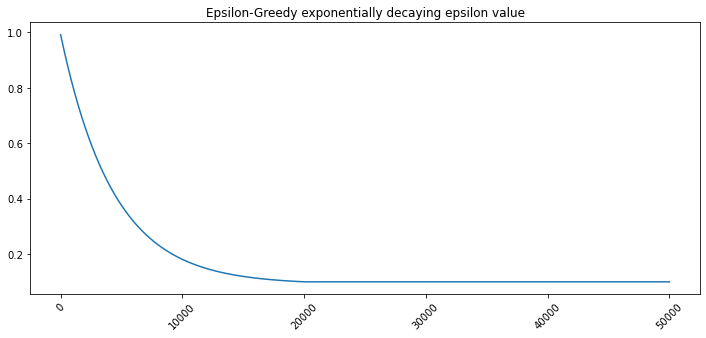

In [25]:
import matplotlib.pyplot as plt

s = EGreedyExpStrategy()

plt.figure(figsize=(12,5))
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy exponentially decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function.

In [26]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()
            return np.argmax(q_values)

We create the Replay Memory, a data structure D to hold experience samples for several steps:

In [27]:
class ReplayMemory():
    def __init__(self, max_size=10000, batch_size=64):
        
        # initialize five arrays to hold states, actions, reward, next states, 
        # and done flags
        self.states      = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.dones       = np.empty(shape=(max_size), dtype=np.ndarray)

        # variables to do storage and sampling
        self.max_size = max_size
        self.batch_size = batch_size
        self.idx = 0
        self.size = 0
    
    def store(self, sample):
        
        # store a new sample 
        state, action, reward, next_state, done = sample
        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = next_state
        self.dones[self.idx] = done

        # idx points to the next index to modify, so we increase it, 
        # also make sure it loops back after reaching the maximum size 
        # (the end of the buffer)
        self.idx += 1
        self.idx = self.idx % self.max_size

        # size also increases with every new sample stored, 
        # but it doesn’t loop back to 0; it stops growing instead
        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        
        # determining the batch size
        if batch_size == None:
            batch_size = self.batch_size

        # sample batch_size ids from 0 to size.    
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        # extract the experiences from the buffer using the sampled ids
        experiences = np.vstack(self.states[idxs]), \
                      np.vstack(self.actions[idxs]), \
                      np.vstack(self.rewards[idxs]), \
                      np.vstack(self.next_states[idxs]), \
                      np.vstack(self.dones[idxs])
        return experiences

    # handy function to return the correct size of the memory
    def __len__(self):
        return self.size

The algorithm has three main steps:
1. collect experience and insert it into the replay memory
2. randomly sample a mini-batch from the replay memory, and calculate the off-policy TD targets for the whole batch
3. fit the action-value function Q(s,a; θ) using MSE and RMSprop

In [28]:
import numpy as np
import random 
import time
from itertools import count
import torch
import torch.optim as optim

class DQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 seed, n_warmup_batches, target_update_steps):
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        self.env = env
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

    def optimize_model(self, experiences):
        
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        max_a_q_sp = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        value_loss.backward()
        self.optimizer.step()

    def interaction_step(self, state):
        
        action = self.train_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = self.env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_memory.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self):
        
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target.data.copy_(online.data)

    def train(self, gamma, max_minutes, max_episodes, goal_mean_100_reward):
        
        training_start = time.time()
        last_debug_time = float('-inf')

        self.gamma = gamma
        
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.update_network()
                    
        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = self.env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state)
                
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:
                    experiences = self.replay_memory.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.target_update_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            total_step = int(np.sum(self.episode_timestep))
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            debug_message = 'episode {:04}, steps {:06}, '
            debug_message += 'avg score {:05.1f}\u00B1{:05.1f}, '
            debug_message = debug_message.format(episode-1, total_step, mean_100_train_reward, std_100_train_reward)
            print(debug_message, end='\r', flush=True)
                   
            if reached_debug_time or training_is_over:
                print(debug_message, flush=True)
                last_debug_time = time.time()
            
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes')
                if reached_max_episodes: print(u'--> reached_max_episodes')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward')
                break
                
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time
    
    def evaluate(self, n_episodes=1):
        
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.eval_strategy.select_action(online_model, s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
                
        return np.mean(rs), np.std(rs)


We can apply the DQN algorithm to the Cart-pole environment:

In [29]:
dqn_results = []
best_dqn_agent, best_dqn_eval_score = None, float('-inf')

gamma = 1.00
max_minutes = 20
max_episodes = 10000
goal_mean_100_reward = 475

target_update_steps = 10
n_warmup_batches = 5

nS, nA = env.observation_space.shape[0], env.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    online_model = FCQ(nS, nA, hidden_dims=(512,128))
    target_model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(online_model.parameters(), lr=0.0005)
    replay_memory = ReplayMemory(max_size=50000, batch_size=64)
    
    train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
    eval_strategy = GreedyStrategy()
    
    
    agent = DQN(env, online_model, target_model, optimizer, 
                train_strategy, eval_strategy, replay_memory, seed, 
                n_warmup_batches, target_update_steps)
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_mean_100_reward)

    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'
          .format(score, score_std, training_time))
    
    dqn_results.append(result)
    if score > best_dqn_eval_score:
        best_dqn_eval_score = score
        best_dqn_agent = agent
        
dqn_results = np.array(dqn_results)

Training started...
episode 0000, steps 000018, avg score 018.0±000.0, 
episode 0184, steps 022504, avg score 201.1±131.7, 
episode 0235, steps 043329, avg score 346.4±156.9, 
episode 0257, steps 053451, avg score 403.0±145.1, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 479.13±57.27 in 147.52s training time

Training started...
episode 0000, steps 000024, avg score 024.0±000.0, 
episode 0181, steps 022752, avg score 198.4±115.1, 
episode 0232, steps 042755, avg score 328.5±134.7, 
episode 0275, steps 061704, avg score 405.5±138.6, 
episode 0281, steps 063963, avg score 412.1±138.8, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 500.00±0.00 in 180.39s training time

Training started...
episode 0000, steps 000017, avg score 017.0±000.0, 
episode 0200, steps 023570, avg score 195.8±120.7, 
episode 0243, steps 043474, avg score 335.3±161.1, 
episode 0274, steps 056737, avg score 410.4±136.6, 
--> reached_goal_mean_reward
...trainin

We can shows performance:

In [30]:
dqn_max_steps, dqn_max_train_reward, dqn_max_eval_score, dqn_max_time = np.max(dqn_results, axis=0).T
dqn_min_steps, dqn_min_train_reward, dqn_min_eval_score, dqn_min_time = np.min(dqn_results, axis=0).T
dqn_mean_steps, dqn_mean_train_reward, dqn_mean_eval_score, dqn_mean_time = np.mean(dqn_results, axis=0).T
dqn_episodes = np.arange(len(dqn_mean_steps))

We can plot the training reward:

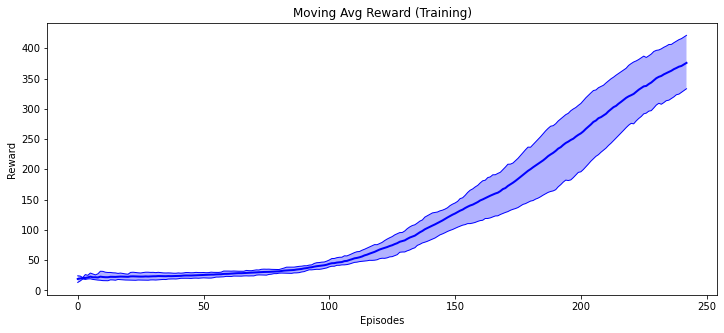

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(dqn_max_train_reward, 'b', linewidth=1)
plt.plot(dqn_min_train_reward, 'b', linewidth=1)
plt.plot(dqn_mean_train_reward, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_train_reward, dqn_max_train_reward, facecolor='b', alpha=0.3)
plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

Plotting the reward during evaluation steps shows the best performance we can obtain from the agent:

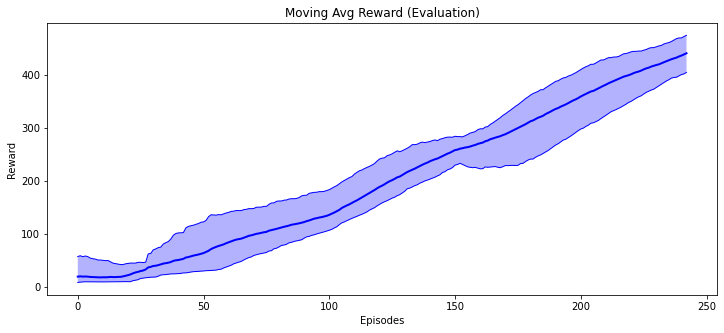

In [35]:
plt.figure(figsize=(12,5))
plt.plot(dqn_max_eval_score, 'b', linewidth=1)
plt.plot(dqn_min_eval_score, 'b', linewidth=1)
plt.plot(dqn_mean_eval_score, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_eval_score, dqn_max_eval_score, facecolor='b', alpha=0.3)
plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

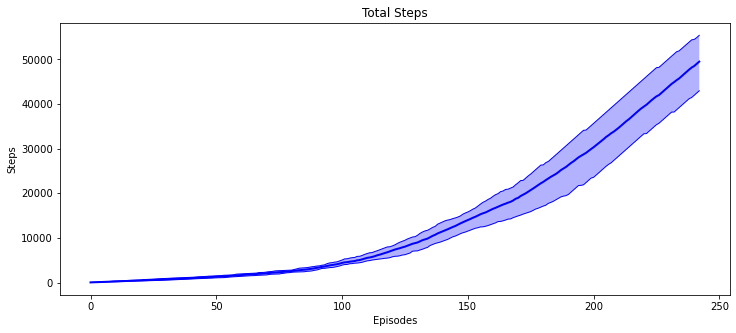

In [36]:
plt.figure(figsize=(12,5))
plt.plot(dqn_max_steps, 'b', linewidth=1)
plt.plot(dqn_min_steps, 'b', linewidth=1)
plt.plot(dqn_mean_steps, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_steps, dqn_max_steps, facecolor='b', alpha=0.3)
plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')
plt.show()